In [1]:
#!pip install pyarrow

In [63]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as optimize
import math
import locale
from google.cloud import bigquery
from common import MUNI_SECURITY_TYPE_DICT, COUPON_TYPE_DICT, COUPON_FREQUENCY_DICT, transform_to_datetime, diff_in_days, actual_diff_in_days, get_next_coupon_date, get_previous_coupon_date, get_time_delta_from_interest_frequency, get_ytw_and_price_data, transform_ytw_and_price_data
from google.api_core.exceptions import BadRequest
from time import sleep
from datetime import datetime,timedelta,date,time
from tqdm import tqdm, tqdm_notebook
from dateutil.relativedelta import relativedelta
from pandas import NaT
sns.set();

locale.setlocale( locale.LC_ALL, 'en_US' )

#tqdm_notebook().pandas()

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../creds.json"

In [70]:
def get_ytw_price_data(bqclient, trade_date):
    query = ''' SELECT
                IFNULL(settlement_date,
                assumed_settlement_date) AS settlement_date,
                trade_date,
                cusip,
                dated_date,
                dollar_price,
                issue_price,
                coupon AS coupon_rate,
                interest_payment_frequency,
                next_call_date,
                par_call_date,
                next_call_price,
                par_call_price,
                basic_assumed_maturity_date,
                assumed_redemption_date AS advanced_assumed_maturity_date,
                maturity_date AS maturity_date,
                previous_coupon_payment_date,
                next_coupon_payment_date,
                first_coupon_date,
                coupon_type,
                muni_security_type,
                called_redemption_type,
                refund_date,
                refund_price,
                is_callable,
                is_called,
                call_timing,
                yield
                FROM `eng-reactor-287421.primary_views.Jul2021Jesse_testing_trade_history_with_reference_data`
                WHERE trade_date = \'''' + trade_date + '''\'
                      AND NOT default_indicator
                      AND maturity_date > DATE_ADD(IFNULL(settlement_date,assumed_settlement_date),INTERVAL 6 month)
                      AND next_call_date > DATE_ADD(IFNULL(settlement_date,assumed_settlement_date),INTERVAL 6 month)
                      --AND is_callable  
                 '''
    dataframe = bqclient.query(query).result().to_dataframe()
    return dataframe   

#### Todo: If MSRB and ICE provide the same field, such as coupon rate, then we should query both and raise a warning if they disagree. This type of checking can be kept clearly separate from the actual calculation code. For some MSRB fields like msrb.dated_date, we want to know how they map to ICE fields such as issue_date.

### we only support Fixed rate, Original issue discount and Zero coupon, for now. Need to expand this:

In [71]:
bqclient = bigquery.Client()
muni_df = get_ytw_price_data(bqclient, '2021-01-13')
transform_ytw_and_price_data(muni_df)
len(muni_df)

/Users/Gil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: PyarrowMissingWarning: Converting to a dataframe without pyarrow installed is often slower and will become unsupported in the future. Please install the pyarrow package.


20186

### Use 360/30 convention for days: 

### get_yield function paramenters should be pruned to the ones needed

In [72]:
def get_price(cusip,dollar_price,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
              interest_payment_frequency,ytw,coupon_rate,par,time_delta):

    # formulas taken from
    # https://www.msrb.org/pdf.aspx?url=https%3A%2F%2Fwww.msrb.org%2FRules-and-Interpretations%2FMSRB-Rules%2FGeneral%2FRule-G-33.aspx
    B = 360 # the number of days in the year (computed in accordance with the provisions of section (e) below);        
    R = coupon_rate/100 
    RV = par # the redemption value of the security per $100 par value; and
    M = interest_payment_frequency 
    Y = ytw/100 # yield is expressed as a decimal
    number_of_interest_payments = 0

    if R != 0 and interest_payment_frequency !=0:
        last_date = next_coupon_date

        # count the coupon payment periods left: 
        while last_date <= end_date:
            number_of_interest_payments += 1
            last_date += time_delta

        final_coupon_date = last_date - time_delta

        if pd.isnull(prev_coupon_date): 
            prev_coupon_date = dated_date

        N = number_of_interest_payments    
        D = diff_in_days(end_date,final_coupon_date) #Time from final Payment to Redemption, can be Zero  
        A = diff_in_days(settlement_date,prev_coupon_date) # accrued days from beginning of the interest payment period
        E = B/M # number of days in interest payment period 

        # one or zero coupon left paid at maturity (or call date)
        if end_date<=next_coupon_date:
            P = round( (RV/100 + R/M)/(1 + ((E-A)*(Y/M)/E)) - A*R/B, 3)
        else:
            S1 = RV/pow((1 + Y/M), (N - 1 + (E-A)/E))
            S2 = 0.0
            for K in range(1,N+1):
                S2 += 1/pow((1 + Y/M), (K - 1 + (E-A)/E))
            S2 *= (100*R/M)
            P = round(S1 + S2 - 100*R*A/B, 3)
    else:
        # Interest at maturity. This also includes zero coupon bonds, i.e. R = 0
        A = diff_in_days(settlement_date,dated_date)
        DIR = diff_in_days(end_date,dated_date)
        P = round( (RV + DIR*R/B)/(1 + ((DIR-A)*Y/B)) - R*A/B, 3)
    
    '''
    if cusip == "717800AB2":
            print(locals())
            print("---------")
    '''        
    return P



In [73]:
A = dict()

In [74]:
def compute_price(trade, use_advanced_maturity=False):

    global A
    time_delta = get_time_delta_from_interest_frequency(trade.interest_payment_frequency)
    my_prev_coupon_date,my_next_coupon_date = None, None 
    if trade.coupon_rate != 0 and trade.interest_payment_frequency != 0:
        my_next_coupon_date = pd.to_datetime(trade.next_coupon_payment_date)
        my_prev_coupon_date = pd.to_datetime(trade.previous_coupon_payment_date)

        if (pd.isnull(trade.previous_coupon_payment_date)):
            my_prev_coupon_date = get_previous_coupon_date(trade.first_coupon_date,trade.settlement_date,time_delta)
        if  (pd.isnull(trade.next_coupon_payment_date)):
            my_next_coupon_date = get_next_coupon_date(trade.first_coupon_date,trade.settlement_date,time_delta)
        if trade.next_coupon_payment_date < trade.settlement_date and pd.isnull(trade.previous_coupon_payment_date):
            my_next_coupon_date = get_next_coupon_date(trade.first_coupon_date,trade.settlement_date,time_delta)
            
    if (not trade.is_called) and (not trade.is_callable):
        par = 100
        end_date = trade.maturity_date
        if use_advanced_maturity:
          end_date = trade.ARD
        return get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                         end_date,trade.settlement_date,trade.dated_date,trade.interest_payment_frequency,
                         trade.yld,trade.coupon_rate,par,time_delta)
            
    elif trade.is_called:
        if trade.called_redemption_type == 1 or trade.called_redemption_type == 5:
            end_date = trade.maturity_date
        else:
            end_date = trade.refund_date
        if use_advanced_maturity: 
          end_date = trade.ARD    
        if not pd.isnull(trade.refund_price):
            par = trade.refund_price
        elif not pd.isnull(trade.next_call_price): 
            par = trade.next_call_price
        else: 
            par = 100
        return get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                         end_date,trade.settlement_date,trade.dated_date,trade.interest_payment_frequency,
                         trade.yld,trade.coupon_rate,par,time_delta)
    
    else:
        par_price = float("inf")
        first_price = float("inf")
        if not pd.isnull(trade.par_call_date):
            par = trade.par_call_price
            end_date = trade.par_call_date
            if use_advanced_maturity: 
              end_date = trade.ARD     
            par_price = get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                      end_date,trade.settlement_date,trade.dated_date,trade.interest_payment_frequency,
                      trade.yld,trade.coupon_rate,par,time_delta)                 

        par = trade.next_call_price
        end_date = trade.next_call_date
        if use_advanced_maturity: 
          end_date = trade.ARD
        first_price = get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                         end_date,trade.settlement_date,trade.dated_date,trade.interest_payment_frequency,
                         trade.yld,trade.coupon_rate,par,time_delta)
        return min(par_price,first_price)

In [75]:
def get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
              interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,
              called_redemption_type,refund_date,guess):

    # Single Trade Debug: remove this last. 
    if cusip == '786285BD7' and dollar_price == 99.800:
        print([cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
             interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,
            called_redemption_type,refund_date,guess])
    
   #Y is the yield
    B = 360 # the number of days in the year (computed in accordance with the provisions of section (e) below);        
    P = dollar_price # the dollar price of the security for each $100 par value;
    R = coupon_rate # the annual interest rate expressed as a percentage, i.e., dollars per $100;
    RV = par # the redemption value of the security per $100 par value; and
    M = interest_payment_frequency 
    number_of_interest_payments = 0

    if R != 0 and interest_payment_frequency !=0: # Coupon paid every M periods
        last_date = next_coupon_date

        # count the coupon payment periods left: 
        while last_date <= end_date: # end_date: maturity_date or next_call_date
            number_of_interest_payments += 1
            last_date += time_delta

        final_coupon_date = last_date - time_delta

        if pd.isnull(prev_coupon_date): prev_coupon_date = dated_date

        N = number_of_interest_payments    
        D = diff_in_days(end_date,final_coupon_date,"360/30") #Time from final Payment to Redemption, can be Zero  
        A = diff_in_days(settlement_date,prev_coupon_date,"360/30") # accrued days from beginning of the interest payment period
        E = B/M # number of days in interest payment period 

        # formula to handle one coupon left paid at maturity (or call date)
        if end_date<=next_coupon_date:
            DTC = diff_in_days(end_date,prev_coupon_date) # accrual days for final paid coupon
            DA = diff_in_days(settlement_date,prev_coupon_date) # accrual days for coupon owed in dirty price
            DM = diff_in_days(end_date,settlement_date) # hold period days
            
            # formula is ((Redemption Value + Coupon Paid at Maturity)/Dirty Price - 1) * 
            # (100 *  Payments per Year)/(Hold Period scaled for payments per year)
            return round( (((RV+(R/M)*(DTC*M/B))/(P+(R/M)*(DA*M/B)))-1)*(M*100)/(DM*M/B),3)

        else:
            #print('P=%s\nRV=%s\nR=%s\nD=%s\nB=%s\nY=%s\nM=%s\nN=%s\nE=%s\nA=%s\nrange(N)==%s\n' %(P,RV,R,D,B,'_',M,N,E,A,range(N)))    
            ytm_func = lambda Y: (RV + R*D/B)/(1+Y/M)**(N-1 + (E-A)/E + D/E) + sum([(R/M)/(1+Y/M)**(K+(E-A)/E) for K in range(N)]) - (P + R*A/B)        
                
    elif R != 0 and interest_payment_frequency == 0:
        # Interest at maturity, Rule 33-G (b)(i)A(b) - why do we get them as negatives??
        A = diff_in_days(settlement_date,dated_date,"360/30")
        DIR = diff_in_days(end_date,dated_date,"360/30")
        ytm_func = lambda Y: ((RV + (DIR/B*R))/(1-((DIR-A)/B*Y)))-(P + R*A/B)
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)*-1 #fix this * -1. (check by pluggin in the positive)
    
    elif R == 0:
        # for Zero coupon use semi annual 360/30 convention
        periods = diff_in_days(end_date,settlement_date)/180.0
        ytm = ((par/P)**(1/periods)-1)*200
        return round(ytm,3)
    try:
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)
    except Exception as e:
        print(e)
        return None
    
#get_yield('645916TV9', pd.to_datetime('2020-10-01 00:00:00'), pd.to_datetime('2003-10-01 00:00:00'), pd.to_datetime('2021-04-01 00:00:00'), date(2021, 2, 6), pd.to_datetime('2021-01-15 00:00:00'), date(2003, 4, 9), 2.0, 108.115, 5.8, 110.0, relativedelta(months=+6), pd.to_datetime('2025-04-01 00:00:00'), True, None, NaT, 0.01)

In [76]:
def compute_assumed_maturity_date(settlement_date,trade_date,cusip,dated_date,dollar_price,coupon_rate,interest_payment_frequency,next_call_date,
                  next_call_price,par_call_date,par_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,
                  coupon_type,muni_security_type,called_redemption_type,refund_date,refund_price,is_callable,call_timing,guess):

    time_delta = get_time_delta_from_interest_frequency(interest_payment_frequency)
    my_prev_coupon_date,my_next_coupon_date = None, None
    # Explain: why is data missing? Why do we need to change an exisiting next_coupon_payment_date?   
    if coupon_rate != 0 and interest_payment_frequency != 0:
        my_next_coupon_date = pd.to_datetime(next_coupon_payment_date)
        my_prev_coupon_date = pd.to_datetime(previous_coupon_payment_date)

        if (pd.isnull(previous_coupon_payment_date)):
            my_prev_coupon_date = get_previous_coupon_date(first_coupon_date,settlement_date,time_delta)
        if  (pd.isnull(next_coupon_payment_date)):
            my_next_coupon_date = get_next_coupon_date(first_coupon_date,settlement_date,time_delta)
        if next_coupon_payment_date < settlement_date and pd.isnull(previous_coupon_payment_date):
            my_next_coupon_date = get_next_coupon_date(first_coupon_date,settlement_date,time_delta)
     
    if not pd.isnull(called_redemption_type) and called_redemption_type != 19 and called_redemption_type != 18: # and coupon_rate !=0: 
        # Bond was Called:
        if called_redemption_type == 1 or called_redemption_type == 5:
            end_date = maturity_date
        else:
            end_date = refund_date              
        if not pd.isnull(refund_price):
            par = refund_price
        elif not pd.isnull(next_call_price): 
            par = next_call_price
        else: 
            par = 100
        ytm = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        return end_date
                    
    if pd.isnull(next_call_date) or pd.isnull(next_call_price):
        # Non callable or no call info:
        end_date = maturity_date
        par = 100
        ytm = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        return end_date
    
    else:
        # Callable:
        
        ytf = float("inf")
        ytm = float("inf")
        yta = float("inf")
        ytp = float("inf")        
        
        if not pd.isnull(par_call_date):
            end_date = par_call_date
            ytp_end_date = par_call_date
            par = par_call_price    
            ytp = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)

        end_date = next_call_date #+ relativedelta(days=1)
        ytf_end_date = next_call_date
        par = next_call_price    
        ytf = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        
        end_date = maturity_date
        ytm_end_date = maturity_date
        par = 100
        ytm = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        
        '''
        # yield to anytime call below does not change anything: 
        if call_timing == 1 and trade_date >= next_call_date - relativedelta(days=30): 
            # calculate 30 days from today only if you are less than 30 days to the next call date: 
            end_date = trade_date + relativedelta(days=30)
            par = 100
            yta = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
            #print(next_call_date)
            #print('ytm: %s, ytf: %s, yta: %s' % (ytm, ytf,yta))
        '''
        yields = (ytf, ytm, yta,ytp)
    
        if cusip == '786285BD7' and dollar_price == 99.800: print('ytm: %s, ytf: %s, yta: %s, ytp: %s' % (ytm, ytf,'yta',ytp))
        if min(yields) == ytf:
            return ytf_end_date
        elif min(yields) == ytm:
            return ytm_end_date
        else:
            return ytp_end_date


In [78]:
guess = 0.01
muni_df['ARD'] = muni_df.apply(lambda x: compute_assumed_maturity_date(x.settlement_date,x.trade_date,x.cusip,x.dated_date,x.dollar_price,x.coupon_rate,x.interest_payment_frequency,x.next_call_date,x.next_call_price,x.par_call_date,x.par_call_price,x.maturity_date,x.previous_coupon_payment_date,x.next_coupon_payment_date,x.first_coupon_date,x.coupon_type,x.muni_security_type,	x.called_redemption_type,	x.refund_date,x.refund_price,	x.is_callable,	x.call_timing,guess),axis=1)

In [79]:
muni_df['yld'] = muni_df.apply(lambda x: getattr(x, 'yield'), axis=1)
muni_df['computed_price_ard'] = muni_df.apply(lambda x: compute_price(x,True),axis=1)

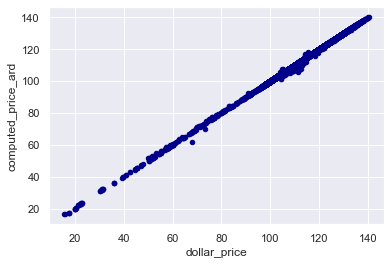

In [81]:
muni_df.plot.scatter(x='dollar_price',y='computed_price_ard', c='DarkBlue')

### the below cells evaluate the results and top discrepancies:

In [83]:
muni_df['ytp_delta'] = muni_df.computed_price_ard - muni_df.dollar_price
muni_df['ytp_error'] = abs(muni_df['ytp_delta']/round(muni_df['dollar_price']))
#len(muni_df[muni_df.computed_price == muni_df['dollar_price']])

In [84]:
pd.set_option('display.max_columns', None)
muni_df.sort_values(by=['ytp_delta'])

,settlement_date,trade_date,cusip,dated_date,dollar_price,issue_price,coupon_rate,interest_payment_frequency,next_call_date,par_call_date,next_call_price,par_call_price,basic_assumed_maturity_date,advanced_assumed_maturity_date,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,called_redemption_type,refund_date,refund_price,is_callable,is_called,call_timing,yield,ARD,yld,computed_price_ard,ytp_delta,ytp_error
19588,2021-01-15,2021-01-13,74529JQF5,2018-08-01,67.860,52.718726,0.00,0.0,2028-07-01,None,86.054839,NaN,2028-07-01,2033-07-01,2033-07-01,NaT,2033-07-01,2033-07-01,Zero coupon,Sales/excise tax,NaN,NaT,NaN,True,False,1.0,3.136,2033-07-01,3.136,61.875,-5.985,0.088015
1064,2021-01-28,2021-01-13,397586RS9,2021-01-15,111.193,111.193812,3.00,2.0,2028-08-15,2028-08-15,100.000000,100.0,2028-08-15,2028-08-15,2037-02-15,NaT,2021-08-15,2021-08-15,Fixed rate,Unlimited G.O.,NaN,NaT,NaN,True,False,1.0,2.170,2028-08-15,2.170,105.750,-5.443,0.049036
7838,2021-01-28,2021-01-13,397586RR1,2021-01-15,111.497,111.497087,3.00,2.0,2028-08-15,2028-08-15,100.000000,100.0,2028-08-15,2028-08-15,2036-02-15,NaT,2021-08-15,2021-08-15,Fixed rate,Unlimited G.O.,NaN,NaT,NaN,True,False,1.0,2.105,2028-08-15,2.105,106.216,-5.281,0.047577
15437,2021-01-28,2021-01-13,397586RQ3,2021-01-15,111.801,111.801300,3.00,2.0,2028-08-15,2028-08-15,100.000000,100.0,2028-08-15,2028-08-15,2035-02-15,NaT,2021-08-15,2021-08-15,Fixed rate,Unlimited G.O.,NaN,NaT,NaN,True,False,1.0,2.030,2028-08-15,2.030,106.757,-5.044,0.045036
12483,2021-01-28,2021-01-13,397586RP5,2021-01-15,112.412,112.412557,3.00,2.0,2028-08-15,2028-08-15,100.000000,100.0,2028-08-15,2028-08-15,2034-02-15,NaT,2021-08-15,2021-08-15,Fixed rate,Unlimited G.O.,NaN,NaT,NaN,True,False,1.0,1.920,2028-08-15,1.920,107.555,-4.857,0.043366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6384,2021-01-15,2021-01-13,036327AE4,2017-02-23,105.000,98.936437,4.25,2.0,2024-11-01,None,103.000000,NaN,2024-11-01,2024-11-01,2027-11-01,2020-11-01,2021-05-01,2017-05-01,Original issue discount,Revenue,NaN,NaT,NaN,True,False,1.0,3.418,2027-11-01,3.418,107.385,2.385,0.022714
6383,2021-01-15,2021-01-13,036327AE4,2017-02-23,105.259,98.936437,4.25,2.0,2024-11-01,None,103.000000,NaN,2024-11-01,2024-11-01,2027-11-01,2020-11-01,2021-05-01,2017-05-01,Original issue discount,Revenue,NaN,NaT,NaN,True,False,1.0,3.377,2027-11-01,3.377,107.646,2.387,0.022733
5693,2021-01-28,2021-01-13,27627MYX9,2021-01-28,115.544,115.544000,4.00,2.0,2027-09-01,None,103.000000,NaN,2027-09-01,2027-09-01,2028-09-01,NaT,2021-03-01,2021-03-01,Fixed rate,Special assessment,NaN,NaT,NaN,True,False,1.0,1.800,2028-09-01,1.800,118.163,2.619,0.022578
960,2021-01-15,2021-01-13,92774NAH3,2018-08-02,114.040,114.331736,5.00,2.0,2025-09-01,None,103.000000,NaN,2025-09-01,2025-09-01,2026-09-01,2020-09-01,2021-03-01,2019-03-01,Fixed rate,Revenue,NaN,NaT,NaN,True,False,1.0,2.324,2026-09-01,2.324,116.672,2.632,0.023088
